In [20]:
import numpy as np
from pr3_utils import *
import transforms3d as tf3
import scipy.linalg as la
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
filename = "../data/03.npz"
t,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(filename)


In [21]:
def mean_update(Tt, gen_vel_t, dt):
    gen_vel_w = gen_vel_t*dt
    exp = axangle2pose(gen_vel_w)
    Tt1 = np.dot(Tt, exp)
    return Tt1

def prediction(mu0, cov0, gen_vel, W, tau):

    mut = np.copy(mu0)
    covt = np.copy(cov0)

    mu_vec = np.zeros((4, 4, tau.shape[0]))
    cov_vec = np.zeros((6,6, tau.shape[0]))
    for i in range(0, tau.shape[0]):
        mu_vec[:, :, i] = mean_update(mut, gen_vel[i, :], tau[i])
        mut = mu_vec[:, :, i]
        _, cov_vec[:, :, i] = cov_update(covt, gen_vel[i, :], W, tau[i])
        covt = cov_vec[:, :, i]
    return mu_vec, cov_vec
        
def cov_update(cov0, gen_vel, W, dt):
    v = gen_vel[0:3]
    w = gen_vel[3:6]
    w_skew = axangle2skew(w)
    v_skew = axangle2skew(v)
    u = np.zeros((6, 6))
    u[0:3, 0:3] = w_skew
    u[3:6, 3:6] = w_skew
    u[0:3, 3:6] = v_skew
    F = la.expm(-dt*u)
    cov = F @ cov0 @ F.T + W
    return F, cov

def calculate_zt1_tilde(mut, Ks, imu_T_cam, Tt1):
    mut_homog = np.append(mut, 1)
    proj = projection(imu_T_cam @ np.linalg.inv(Tt1) @ mut_homog)
    zt1_tilde = Ks @ proj
    return zt1_tilde

def calculate_Ht1(Tt1, mut, Ks, imu_T_cam, P):
    mu_tj_homog = np.append(mut, 1)
    jacobian = projectionJacobian(imu_T_cam @ np.linalg.inv(Tt1) @ mu_tj_homog)
    
    H1t = Ks @ jacobian @ imu_T_cam @ np.linalg.inv(Tt1) @ P.T
    return H1t

def calculate_Kt1(covt, Ht1, V):
    Kt1 = covt @ (Ht1.T @ np.linalg.inv(Ht1 @ covt @ Ht1.T + V))
    return Kt1

def calculate_mut1(mut, Kt1, zt1, zt1_tilde):
    mut1 = mut + Kt1@(zt1 - zt1_tilde)
    return mut1

def calculate_covt1(covt, Kt1, Ht1):
    covt1 = (np.eye(6) - Kt1 @ Ht1) @ covt
    return covt1

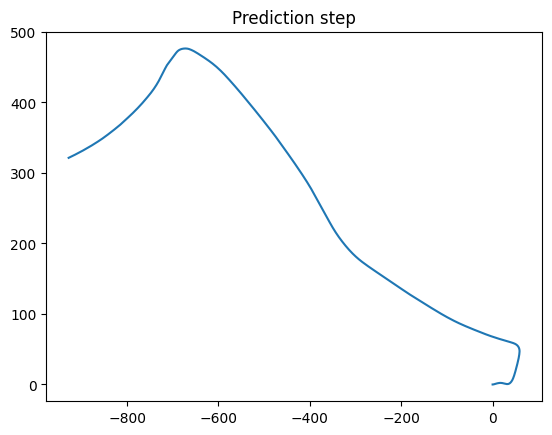

In [22]:
# N
tau = np.diff(t).T

# Nx3
lin_vel = linear_velocity[:, :-1].T
ang_vel = angular_velocity[:, :-1].T

# Nx6
gen_vel = np.concatenate((lin_vel, ang_vel), axis=1)

mu0 = np.eye(4)
cov0 = np.diag([10e-3, 10e-3, 10e-3, 10e-4, 10e-4, 10e-4])
W = np.diag([10e-1, 10e-2, 10e-2, 10e-5, 10e-5, 10e-4])

# 4x4xN, 6x6xN
mu_predictions, cov_predictions = prediction(mu0, cov0, gen_vel, W, tau)

plt.figure(1)
plt.plot(mu_predictions[0, 3, :], mu_predictions[1, 3, :], label="Estimated trajectory")
plt.title("Prediction step")
plt.show()

In [23]:
# Downsample features
features_downsampled = features[:, ::5, :]
print(features.shape)
print(features_downsampled.shape)

(4, 5105, 1010)
(4, 1021, 1010)


In [24]:
def initialize_landmarks(features, poses, K, imu_T_cam):
    fsu = K[0, 0]
    cu = K[0, 2]
    cv = K[1, 2]

    m_vec = np.zeros((3, features.shape[1]))

    i_idx = set()

    for t in range(0, features.shape[2]):
        for i in range(0, features.shape[1]):
            if features[0, i, t] != -1 and features[2, i, t] != -1:
                if i not in i_idx:
                    uL = features[0, i, t]
                    vL = features[1, i, t]
                    uR = features[2, i, t]

                    d = uL-uR

                    z = fsu*b/d

                    x = (uL - cu)*z/fsu
                    y = (vL - cv)*z/fsu

                    m_cam_homog = np.array([x, y, z, 1])
                    m_imu_homog = imu_T_cam @ m_cam_homog
                    m_world_homog = poses[:, :, t] @ m_imu_homog

                    m_vec[0, i] = m_world_homog[0] / m_world_homog[3]
                    m_vec[1, i] = m_world_homog[1] / m_world_homog[3]
                    m_vec[2, i] = m_world_homog[2] / m_world_homog[3]

                    i_idx.add(i)
                    if len(i_idx) == features.shape[1]:
                        print("Done Initializing Landmarks")
                        return m_vec
    return m_vec    

Done Initializing Landmarks
(3, 1021)


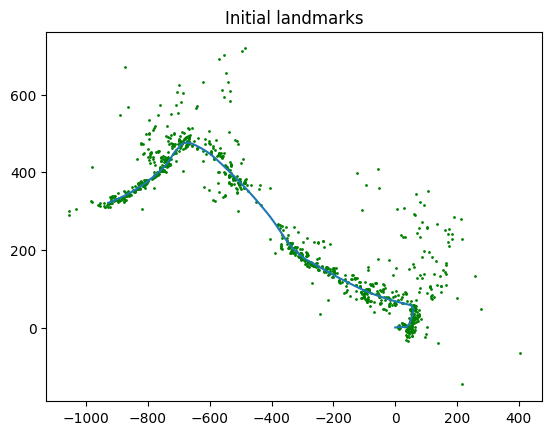

In [25]:
m_init = initialize_landmarks(features_downsampled, mu_predictions, K, imu_T_cam)
print(m_init.shape)
plt.figure(1)
plt.scatter(m_init[0, :], m_init[1, :], s=1,label="landmarks",c='g')
plt.plot(mu_predictions[0, 3, :], mu_predictions[1, 3, :], label="Estimated trajectory")
plt.title("Initial landmarks")
plt.show()

In [26]:

def update_landmarks(m_init, features, poses, Ks, o_T_i, m_cov0, V, P):
    m_flat = m_init.flatten(order='F')
    cov_t = csr_matrix(np.kron(np.eye(m_init.shape[1]), m_cov0))
    sparse_eye = csr_matrix(np.eye(3*features.shape[1]))

    for t in range(poses.shape[2]):
        size = np.sum(features[0, :, t] != -1)
        Ht1_vec = np.zeros((4*size, 3*m_init.shape[1]))
        zt1_vec = np.zeros((4*size))
        zt1_tilde_vec = np.zeros((4*size))
        noise = csr_matrix(np.kron(np.eye(size), V))

        j = 0
        for i in range(features.shape[1]):
            if features[0, i, t] != -1:
                m = m_flat[i*3:i*3+3]
                m_homog = np.append(m, 1)
                
                zt1 = features[:, i, t]
                zt1_vec[j*4:j*4+4] = zt1
                z1_tilde = Ks @ projection(o_T_i @ np.linalg.inv(poses[:, :, t]) @ m_homog)

                zt1_tilde_vec[j*4:j*4+4] = z1_tilde
                Ht1 = Ks @ projectionJacobian(o_T_i @ np.linalg.inv(poses[:, :, t]) @ m_homog) @ o_T_i @ np.linalg.inv(poses[:, :, t]) @ P.T
                Ht1_vec[j*4:j*4+4, i*3:i*3+3] = Ht1
                j += 1
                
        Ht1_vec = csr_matrix(Ht1_vec)

        try:
            Kt1 = cov_t @ Ht1_vec.T @ inv(Ht1_vec @ cov_t @ Ht1_vec.T + noise)
            m_flat = m_flat + Kt1 @ (zt1_vec - zt1_tilde_vec)
            cov_t = (sparse_eye - Kt1 @ Ht1_vec) @ cov_t
        except:
            print("Singular matrix")
        
        tr = np.trace(cov_t.toarray())
        print(t, "Tr(Cov): ", tr, end='\r')
    return m_flat.reshape((3, -1), order='F'), cov_t


In [27]:
cov0_m = np.eye(3)*10e-6
V = np.eye(4)*10e-4
fsu = K[0,0]
fsv = K[1,1]
cu = K[0,2]
cv = K[1,2]
b = 0.6 

Ks = np.array([[fsu, 0, cu, 0],
               [0, fsv, cv, 0],
               [fsu, 0, cu, -fsu*b],
               [0, fsv, cv, 0]])

Ks2 = np.array([[fsv, 0, cu, 0],
               [0, fsu, cv, 0],
               [fsv, 0, cu, -fsu*b],
               [0, fsu, cv, 0]])
P = np.zeros((3, 4))
# 
P = np.zeros((3, 4))
P[0:3, 0:3] = np.eye(3)

o_T_c = np.array([[0, -1, 0, 0],
                 [0, 0, -1, 0],
                 [1, 0, 0, 0],
                 [0, 0, 0, 1]])

o_T_i = np.linalg.inv(imu_T_cam)
# o_T_i = np.eye(4)


m_update, cov_landmaks = update_landmarks(m_init, features_downsampled, mu_predictions, Ks, o_T_i, cov0_m, V, P)

c:\Users\haako\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\haako\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


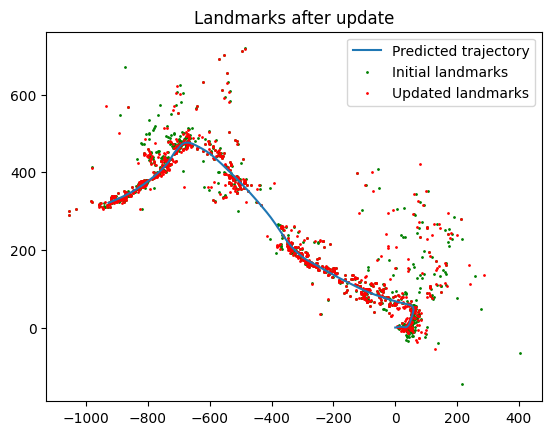

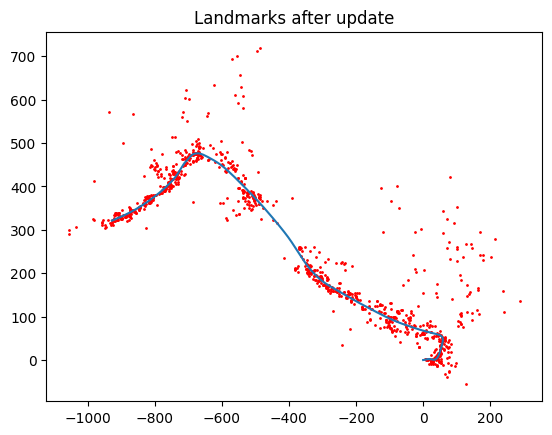

(3, 1021)
(4, 1021, 1010)


In [28]:
plt.figure(2)
plt.plot(mu_predictions[0, 3, :], mu_predictions[1, 3, :], label="Predicted trajectory")
plt.scatter(m_init[0, :], m_init[1, :], s=1,label="Initial landmarks",c='g')
plt.scatter(m_update[0, :], m_update[1, :], s=1,label="Updated landmarks",c='r')
plt.legend()
plt.title("Landmarks after update")
plt.show()

plt.figure(3)
plt.plot(mu_predictions[0, 3, :], mu_predictions[1, 3, :], label="Estimated trajectory")
plt.scatter(m_update[0, :], m_update[1, :], s=1,label="landmarks",c='r')
plt.title("Landmarks after update")
plt.show()

print(m_init.shape)
print(features_downsampled.shape)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

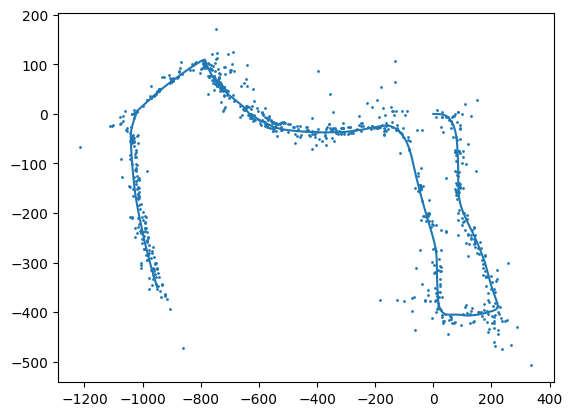

In [10]:
from sklearn.linear_model import RANSACRegressor


def remove_outliers(points, features, model, residual_threshold=200.0):
    points = np.copy(points).T

    model.fit(points[:, :2], points[:, 2])
    residuals = np.abs(model.predict(points[:, :2]) - points[:, 2])
    outliers = residuals > residual_threshold

    cleaned_points = points[~outliers, :]
    cleaned_features = features[:, ~outliers, :]

    return cleaned_points.T, cleaned_features

ransac_model = RANSACRegressor()
cleaned_points, cleaned_features = remove_outliers(m_init, features_downsampled, ransac_model)

plt.figure(5)
plt.plot(mu_predictions[0, 3, :], mu_predictions[1, 3, :], label="Estimated trajectory")
plt.scatter(cleaned_points[0, :], cleaned_points[1,:], s=1)
plt.plot

In [11]:
def EKF_slam(pose_init, pose_predictions, pose_cov0, gen_vel, W, tau, m_init, features, Ks, o_T_i, m_cov0, V, P):
    
    m_flat = m_init.flatten(order='F').astype(np.float64)
    pose_t = np.copy(pose_init).astype(np.float64)
    pose_updated = np.copy(pose_predictions).astype(np.float64)

    cov_landmarks_t = np.kron(np.eye(m_init.shape[1]), m_cov0).astype(np.float64)
    cov_pose_t = pose_cov0.astype(np.float64)
    cov_t = csr_matrix(la.block_diag(cov_landmarks_t, cov_pose_t), dtype=np.float64)
    
    for t in range(pose_predictions.shape[2]):

        # Prediction
        cov_RR = cov_t[cov_landmarks_t.shape[0]:, cov_landmarks_t.shape[0]:]
        cov_RL = cov_t[cov_landmarks_t.shape[0]:, 0:cov_landmarks_t.shape[0]]
        cov_LR = cov_t[0:cov_landmarks_t.shape[0], cov_landmarks_t.shape[0]:]

        F, cov_RRt = cov_update(cov_RR, gen_vel[t, :], W, tau[t])
        cov_RLt = F @ cov_RL
        cov_LRt = cov_LR @ F.T

        cov_t[cov_landmarks_t.shape[0]:, cov_landmarks_t.shape[0]:] = cov_RRt
        cov_t[cov_landmarks_t.shape[0]:, 0:cov_landmarks_t.shape[0]] = cov_RLt
        cov_t[0:cov_landmarks_t.shape[0], cov_landmarks_t.shape[0]:] = cov_LRt

        pose_pred = mean_update(pose_t, gen_vel[t, :], tau[t])

        # Case singularity:
        pose_t = pose_pred


        size = np.sum(features[0, :, t] != -1)
        Ht1_landmark_vec = np.zeros((4*size, 3*m_init.shape[1]), dtype=np.float64)
        Ht1_robot_vec = np.zeros((4*size, 6), dtype=np.float64)
        zt1_vec = np.zeros((4*size), dtype=np.float64)
        zt1_tilde_vec = np.zeros((4*size), dtype=np.float64)
        noise = csr_matrix(np.kron(np.eye(size), V), dtype=np.float64)

        
        j = 0
        for i in range(features.shape[1]):
            if features[0, i, t] != -1:
                m = m_flat[i*3:i*3+3]
                m_homog = np.append(m, 1)
                
                
                zt1 = features[:, i, t].astype(np.float64)
                zt1_vec[j*4:j*4+4] = zt1
                z1_tilde = Ks @ projection(o_T_i @ np.linalg.inv(pose_pred) @ m_homog)
                zt1_tilde_vec[j*4:j*4+4] = z1_tilde

                # Ht1 robot
                jacobian_landmark = projectionJacobian(o_T_i @ np.linalg.inv(pose_pred) @ m_homog)
                to_skew = np.linalg.inv(pose_pred) @ m_homog
                s = to_skew[0:3]
                s_skew = axangle2skew(s)
                homog_skew = np.zeros((4, 6))
                homog_skew[0:3, 3:6] = -s_skew
                homog_skew[0:3, 0:3] = np.eye(3)
                Ht1_robot = - Ks @ jacobian_landmark @ o_T_i @ homog_skew
                Ht1_robot_vec[j*4:j*4+4, :] = Ht1_robot

                # Ht1 landmark
                Ht1_landmark = Ks @ projectionJacobian(o_T_i @ np.linalg.inv(pose_pred) @ m_homog) @ o_T_i @ np.linalg.inv(pose_pred) @ P.T
                Ht1_landmark_vec[j*4:j*4+4, i*3:i*3+3] = Ht1_landmark
                j += 1
        try:

            cov_t = 0.5*(cov_t + cov_t.T)
            Ht1 = np.concatenate((Ht1_landmark_vec, Ht1_robot_vec), axis=1)
            
            Ht1 = csr_matrix(Ht1, dtype=np.float64)

            Kt1 = cov_t @ Ht1.T @ inv(Ht1 @ cov_t @ Ht1.T + noise)
            cov_t = (csr_matrix(np.eye(cov_t.shape[0]), dtype=np.float64) - Kt1 @ Ht1) @ cov_t
                
            updated = Kt1 @ (zt1_vec - zt1_tilde_vec)
            
            m_flat = m_flat + updated[6:].astype(np.float64)
            pose_angax = updated[0:6].astype(np.float64)

            pose_t = pose_pred @ axangle2pose(pose_angax)
            pose_updated[:, :, t] = pose_t
        except:
            print("Singular matrix")

        tr = np.trace(cov_t.toarray())
        print(t, "Tr(Cov): ", tr, end='\r')
    return pose_updated, m_flat.reshape((3, -1), order='F').astype(np.float64), cov_t

In [16]:

pose_init = np.eye(4)
pose_cov0 = np.diag([10e-3, 10e-3, 10e-3, 10e-4, 10e-4, 10e-4])*10e-4

W = np.diag([10e-1, 10e-2, 10e-2, 10e-5, 10e-5, 10e-4])*10e-4
m_cov0 = np.eye(3)*10e-4
V = np.eye(4)   

R = tf3.euler.euler2mat(np.pi, 0, 0, 'sxyz')

# TR = np.eye(4) 
# TR[0:3, 0:3] = R
# p = np.array([-0.81, 0, 0])

o_T_i_2 =   o_T_i
pose_init_2 = pose_init 

pose_updated, m_updated, cov_updated = EKF_slam(pose_init, mu_predictions, pose_cov0, gen_vel, W, tau, cleaned_points, cleaned_features, Ks, o_T_i_2, m_cov0, V, P)


c:\Users\haako\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\haako\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\haako\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Singular matrix.5433735963035464
Singular matrix.5450759765763316
Singular matrix.546790659745371
Singular matrix.5714221026154647
Singular matrix.5732651432271565
Singular matrix.8226008865406618
Singular matrix.4193393181085407
Singular matrix.4204016175276095
Singular matrix.4214691466590454
Singular matrix2.5910296883459327
Singular matrix2.593623924507575
Singular matrix2.5962393937591477
Singular matrix2.598886735016234
Singular matrix2.6015633948658294
Singular matrix2.6042835397518047
Singular matrix2.6070420345473897
Singular matrix2.6292639757510486
Singular matrix3.0787480207085834
Singular matrix3.0811145815506946
Singular matrix3.0835055107963987
Singular matrix3.0859268022140225
Singular matrix3.0883779991517226
Singular matrix3.090867154528251
Singular matrix3.093397850825647
Singular matrix3.0959743126399477
Singular matrix3.1087568675365163
Singular matrix3.1114204845430855
Singular matrix3.11411386617515
Singular matrix3.1168443387940115
Singular matrix3.2206040174620

In [17]:
def remove_outliers2(points, model, residual_threshold=200.0):
    points = np.copy(points).T

    model.fit(points[:, :2], points[:, 2])
    residuals = np.abs(model.predict(points[:, :2]) - points[:, 2])
    outliers = residuals > residual_threshold

    cleaned_points = points[~outliers, :]

    return cleaned_points.T

m_new = remove_outliers2(m_updated, ransac_model)

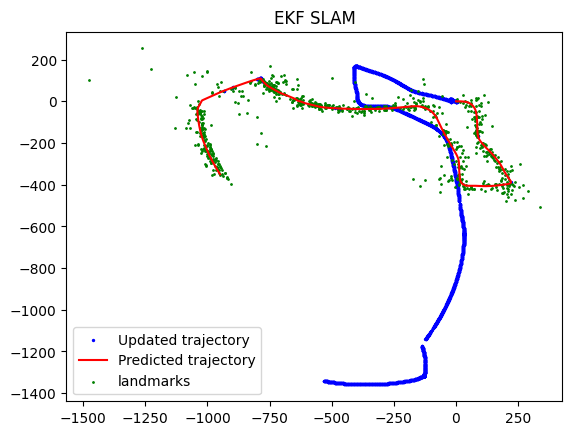

In [19]:
# print(m_updated.shape)

# m_updated_outlier = np.where(m_updated[0, :] < -1000)
# m_updated_new = np.delete(m_updated, m_updated_outlier, axis=1)

plt.figure(3)
plt.scatter(pose_updated[0, 3, :], pose_updated[1, 3, :], s=2, label="Updated trajectory", c='b')
plt.plot(mu_predictions[0, 3, :], mu_predictions[1, 3, :], label="Predicted trajectory", c='r')
plt.scatter(m_new[0, :], m_new[1, :], s=1,label="landmarks",c='g')
plt.legend()
plt.title("EKF SLAM")
plt.show()